In [1]:
from astropy.io import fits
from astropy.table import Table
from astropy.io.fits import getdata
import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import math
from multiprocessing import Pool
from pandas import DataFrame

In [3]:
dir_name = '/home/s1/djsuson/data/'
combo_file_name = 'delve_hsc_cat.fits'
delve_file_name = 'delve_overlap.fits'
hsc_file_name = 'hsc_overlap.fits'
combo_all_data = getdata(dir_name+combo_file_name, 1)
delve_all_data = getdata(dir_name+delve_file_name, 1)
hsc_all_data = getdata(dir_name+hsc_file_name, 1)

There are 125 pixels in the combined catalog


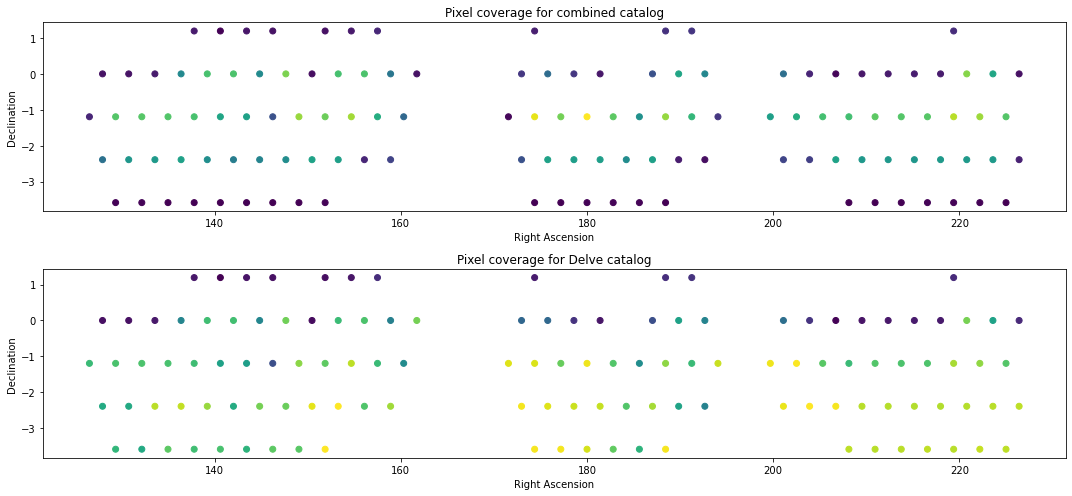

In [4]:
nSides = 32
sub_nSides = 4096
bins = int(sub_nSides / nSides)
channel = 'I'

indices = (combo_all_data[f'MAG_AUTO_{channel}'] < 26)
combo_data = combo_all_data[indices]
indices = (delve_all_data[f'MAG_AUTO_{channel}'] < 56)
delve_data = delve_all_data[indices]

combo_pixel_coverage = {}
combo_pixel_coverage['dec'] = []
combo_pixel_coverage['ra'] = []
combo_pixel_coverage['occupancy'] = []
delve_pixel_coverage = {}
delve_pixel_coverage['dec'] = []
delve_pixel_coverage['ra'] = []
delve_pixel_coverage['occupancy'] = []

combo_pixels = hp.ang2pix(nSides, combo_data['RA'], combo_data['DEC'], lonlat=True)
delve_pixels = hp.ang2pix(nSides, delve_data['RA'], delve_data['DEC'], lonlat=True)
pixel_list = np.unique(combo_pixels)
print(f'There are {len(pixel_list)} pixels in the combined catalog')

for pixel in pixel_list:
    # look at subpixel coverage for combined data
    indices = (combo_pixels == pixel)
    pixel_data = combo_data[indices]
    subpixels = hp.ang2pix(sub_nSides, pixel_data['RA'], pixel_data['DEC'], lonlat=True)
    subpixel_list = np.unique(subpixels)
    occupancy = len(subpixel_list) / (1.0 * bins**2)
    pix_ra, pix_dec = hp.pix2ang(nSides, pixel, lonlat=True)
    combo_pixel_coverage['dec'].append(pix_dec)
    combo_pixel_coverage['ra'].append(pix_ra)
    combo_pixel_coverage['occupancy'].append(occupancy)

    # look at subpixel coverage for delve data
    indices = (delve_pixels == pixel)
    pixel_data = delve_data[indices]    
    subpixels = hp.ang2pix(sub_nSides, pixel_data['RA'], pixel_data['DEC'], lonlat=True)
    subpixel_list = np.unique(subpixels)
    occupancy = len(subpixel_list) / (1.0 * bins**2)
    pix_ra, pix_dec = hp.pix2ang(nSides, pixel, lonlat=True)
    delve_pixel_coverage['dec'].append(pix_dec)
    delve_pixel_coverage['ra'].append(pix_ra)
    delve_pixel_coverage['occupancy'].append(occupancy)

# plot pixel coverage for combined and Delve data
fig1, ax1 = plt.subplots(2,1,figsize=(15,7))

ax1[0].scatter(combo_pixel_coverage['ra'], combo_pixel_coverage['dec'], c=combo_pixel_coverage['occupancy'])
ax1[0].set_xlabel('Right Ascension')
ax1[0].set_ylabel('Declination')
ax1[0].set_title('Pixel coverage for combined catalog')

ax1[1].scatter(delve_pixel_coverage['ra'], delve_pixel_coverage['dec'], c=delve_pixel_coverage['occupancy'])
ax1[1].set_xlabel('Right Ascension')
ax1[1].set_ylabel('Declination')
ax1[1].set_title('Pixel coverage for Delve catalog')
plt.tight_layout()

0.9715576171875 0.9996337890625


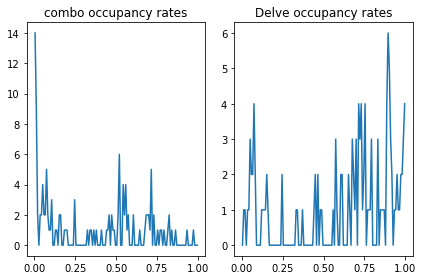

In [5]:
print(np.max(combo_pixel_coverage['occupancy']), np.max(delve_pixel_coverage['occupancy']))

fig2, ax2 = plt.subplots(1, 2)

mag_hist, mag_edges = np.histogram(combo_pixel_coverage['occupancy'], range=(0,1), bins=bins)
bin_centers = 0.5 * mag_edges[1:] + 0.5 * mag_edges[:-1]
ax2[0].plot(bin_centers, mag_hist)
ax2[0].set_title('combo occupancy rates')

mag_hist, mag_edges = np.histogram(delve_pixel_coverage['occupancy'], range=(0,1), bins=bins)
bin_centers = 0.5 * mag_edges[1:] + 0.5 * mag_edges[:-1]
ax2[1].plot(bin_centers, mag_hist)
ax2[1].set_title('Delve occupancy rates')
plt.tight_layout()

In [6]:
min_coverage = 0.61

combo_df = DataFrame(combo_pixel_coverage, columns=['dec','ra','occupancy'])
indices = (combo_df['occupancy'] > min_coverage)
full_pixels = pixel_list[indices]
print(f'There are {len(full_pixels)} pixels with {min_coverage*100}% coverage in the combined catalog')

indices = np.isin(combo_pixels, full_pixels)
combo_full = combo_data[indices]
print(f'There are {len(combo_full)} objects in the combined catalog at this coverage')

indices = np.isin(delve_pixels, full_pixels)
delve_full = delve_data[indices]
print(f'There are {len(delve_full)} objects in the Delve catalog at this coverage')

There are 27 pixels with 61.0% coverage in the combined catalog
There are 2270807 objects in the combined catalog at this coverage
There are 2482203 objects in the Delve catalog at this coverage


Text(0.5, 0.98, '0.61 pixel coverage')

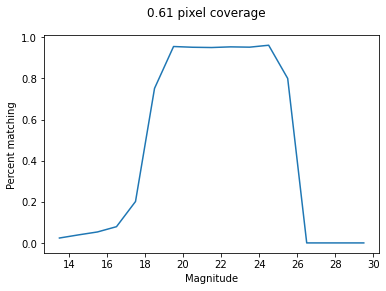

In [8]:
bright = math.floor(np.min(delve_full[f'MAG_AUTO_{channel}']))
dim = math.ceil(np.max(delve_full[f'MAG_AUTO_{channel}']))
bins = int(dim - bright)

combo_hist, _ = np.histogram(combo_full[f'MAG_AUTO_{channel}'], range=(bright,dim), bins=bins)
delve_hist, mag_edges = np.histogram(delve_full[f'MAG_AUTO_{channel}'], range=(bright,dim), bins=bins)
bin_centers = 0.5 * mag_edges[1:] + 0.5 *mag_edges[:-1]
ratio = 1.0 * combo_hist / delve_hist
plt.plot(bin_centers, ratio)
plt.xlabel('Magnitude')
plt.ylabel('Percent matching')
plt.suptitle(f'{min_coverage} pixel coverage')

Text(0.5, 0.98, '0.61 pixel coverage')

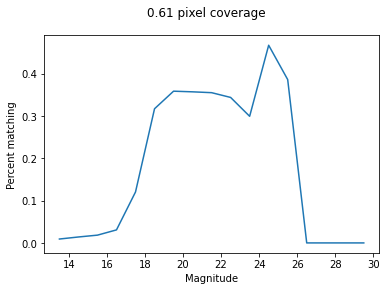

In [9]:
indices = (combo_df['occupancy'] < min_coverage)
partial_pixels = pixel_list[indices]

indices = np.isin(combo_pixels, partial_pixels)
combo_partial = combo_data[indices]

indices = np.isin(delve_pixels, partial_pixels)
delve_partial = delve_data[indices]

bright = math.floor(np.min(delve_partial[f'MAG_AUTO_{channel}']))
dim = math.ceil(np.max(delve_partial[f'MAG_AUTO_{channel}']))
bins = int(dim - bright)

combo_hist, _ = np.histogram(combo_partial[f'MAG_AUTO_{channel}'], range=(bright,dim), bins=bins)
delve_hist, mag_edges = np.histogram(delve_partial[f'MAG_AUTO_{channel}'], range=(bright,dim), bins=bins)
bin_centers = 0.5 * mag_edges[1:] + 0.5 *mag_edges[:-1]
ratio = 1.0 * combo_hist / delve_hist

plt.plot(bin_centers, ratio)
plt.xlabel('Magnitude')
plt.ylabel('Percent matching')
plt.suptitle(f'{min_coverage} pixel coverage')